# Vehicle Routing Problem with Time Windows (VRPTW)

This notebook demonstrates how to model the **Vehicle Routing Problem with Time Windows (VRPTW)** using pycsp3-scheduling.

## Problem Description

In the VRPTW:
- A fleet of **vehicles** starts and ends at a **depot**
- Each vehicle must visit a subset of **customers**
- Each customer has a **time window** $[e_i, l_i]$ for when service can begin
- Each customer has a **demand** and each vehicle has **capacity**
- **Objective**: Minimize total travel distance

## Mathematical Model

**Sets**:
- $V$ = set of vehicles
- $C$ = set of customers
- $N = C \cup \{0\}$ = customers plus depot (node 0)

**Parameters**:
- $e_i, l_i$ = earliest/latest start time for customer $i$
- $s_i$ = service duration at customer $i$
- $d_i$ = demand of customer $i$
- $Q$ = vehicle capacity
- $t_{ij}$ = travel time/distance from $i$ to $j$

**Variables**:
- $visit_{v,i}$ = interval for vehicle $v$ visiting customer $i$ (optional)
- $route_v$ = sequence of visits for vehicle $v$

**Constraints**:
1. **Time windows**: Service must start within $[e_i, l_i]$
2. **Coverage**: Each customer visited by exactly one vehicle
3. **Capacity**: Total demand on each route $\leq Q$
4. **Travel time**: Sufficient time between consecutive visits

**Objective**: Minimize total travel distance
$$\min \sum_{v \in V} \left( t_{0,first(v)} + \sum_{i,j \text{ consecutive in } route_v} t_{ij} + t_{last(v),0} \right)$$

In [1]:
# Imports
from pycsp3 import *
from pycsp3_scheduling import *
from pycsp3_scheduling.variables.interval import clear_interval_registry
from pycsp3_scheduling.expressions.element import ElementMatrix

print("Imports successful!")

Imports successful!


## Problem Data

A small instance with 6 customers and 3 vehicles:

In [2]:
# Problem data
n_vehicles = 3
n_customers = 6
vehicle_capacity = 15

# Customer data: (earliest, latest, service_time, demand)
# Index 0 is depot, 1-6 are customers
customers = [
    (0, 100, 0, 0),    # Depot: available [0,100], no service time, no demand
    (10, 80, 5, 3),    # Customer 1
    (20, 80, 8, 5),    # Customer 2
    (15, 45, 6, 4),    # Customer 3
    (15, 30, 4, 6),    # Customer 4
    (25, 50, 7, 3),    # Customer 5
    (40, 80, 5, 4),    # Customer 6
]

# Travel times matrix (symmetric)
# travel[i][j] = time to go from i to j
travel = [
    [0, 10, 15, 12, 20, 18, 25],  # From depot
    [10, 0, 8, 10, 15, 12, 20],   # From customer 1
    [15, 8, 0, 6, 10, 8, 15],     # From customer 2
    [12, 10, 6, 0, 12, 10, 18],   # From customer 3
    [20, 15, 10, 12, 0, 6, 10],   # From customer 4
    [18, 12, 8, 10, 6, 0, 8],     # From customer 5
    [25, 20, 15, 18, 10, 8, 0],   # From customer 6
]

print("VRPTW Instance:")
print(f"  Vehicles: {n_vehicles} (capacity: {vehicle_capacity})")
print(f"  Customers: {n_customers}")
print()
print("Customer data:")
print(f"  {'ID':<4} {'Window':<12} {'Service':<8} {'Demand':<6}")
for i, (e, l, s, d) in enumerate(customers):
    if i == 0:
        print(f"  {i:<4} [{e:>3}, {l:>3}]     {'depot':<8} {'-':<6}")
    else:
        print(f"  {i:<4} [{e:>3}, {l:>3}]     {s:<8} {d:<6}")



VRPTW Instance:
  Vehicles: 3 (capacity: 15)
  Customers: 6

Customer data:
  ID   Window       Service  Demand
  0    [  0, 100]     depot    -     
  1    [ 10,  80]     5        3     
  2    [ 20,  80]     8        5     
  3    [ 15,  45]     6        4     
  4    [ 15,  30]     4        6     
  5    [ 25,  50]     7        3     
  6    [ 40,  80]     5        4     


## Building the Model

We model each customer visit as an optional interval. Each customer must be visited by exactly one vehicle.

In [3]:
# Clear any previous model state
clear()
clear_interval_registry()

# Create a depot interval per vehicle (fictive visit fixed at time 0)
depots = []

# Create visit intervals for each (vehicle, customer) pair
# visits[v][c] = interval for vehicle v visiting customer c
visits = []
for v in range(n_vehicles):
    depot = IntervalVar(
        start=0,
        size=0,
        name=f"V{v}_Depot"
    )
    depots.append(depot)
    vehicle_visits = []
    for c in range(1, n_customers + 1):  # Skip depot (index 0)
        earliest, latest, service, demand = customers[c]
        visit = IntervalVar(
            start=(earliest, latest),  # Time window constraint built into bounds
            size=service,
            optional=True,
            name=f"V{v}_C{c}"
        )
        vehicle_visits.append(visit)
    visits.append(vehicle_visits)

print(f"Created {n_vehicles} depot intervals fixed at time 0")
print(f"Created {n_vehicles * n_customers} optional visit intervals")
print(f"  visits[vehicle][customer-1] for customer 1..{n_customers}")


Created 3 depot intervals fixed at time 0
Created 18 optional visit intervals
  visits[vehicle][customer-1] for customer 1..6


In [4]:
# Create main (abstract) visit interval for each customer
# This represents "customer c is visited" regardless of which vehicle
main_visits = []
for c in range(1, n_customers + 1):
    earliest, latest, service, demand = customers[c]
    main = IntervalVar(
        start=(earliest, latest),
        size=service,
        name=f"C{c}"
    )
    main_visits.append(main)

print(f"Created {n_customers} main visit intervals")

Created 6 main visit intervals


In [5]:
# Alternative constraint: each customer visited by exactly one vehicle
# Only for customer visits (indices 0..n_customers-1), not depot
for c in range(n_customers):
    alternatives_for_c = [visits[v][c] for v in range(n_vehicles)]
    satisfy(alternative(main_visits[c], alternatives_for_c))

print("Alternative constraints: each customer assigned to exactly one vehicle")

Alternative constraints: each customer assigned to exactly one vehicle


In [6]:
# Create sequence variable for each vehicle route
# The sequence determines the order of visits (depot + customers)
routes = []
for v in range(n_vehicles):
    # Types align with travel matrix indices: 0=depot, 1..n_customers=customers
    types = [0] + [c + 1 for c in range(n_customers)]
    route = SequenceVar(
        intervals=[depots[v]] + visits[v],
        types=types,
        name=f"route_{v}"
    )
    routes.append(route)

print(f"Created {n_vehicles} route sequences")


Created 3 route sequences


In [7]:
# Build transition matrix for travel times (includes depot as type 0)
# transition[i][j] = travel time from type i to type j
transition_matrix = [row[:] for row in travel]

# No-overlap with travel times on each route
for v in range(n_vehicles):
    satisfy(SeqNoOverlap(routes[v], transition_matrix=transition_matrix))

print("Travel time constraints added via SeqNoOverlap with transition matrix")
print(f"  Example: C2 -> C3 requires {travel[2][3]} time units")


Travel time constraints added via SeqNoOverlap with transition matrix
  Example: C2 -> C3 requires 6 time units


In [8]:
# Capacity constraint: total demand on each route <= capacity
# Only sum over customer visits (indices 0..n_customers-1), not depot
for v in range(n_vehicles):
    route_demand = Sum(
        customers[c+1][3] * presence_time(visits[v][c])  # demand * presence
        for c in range(n_customers)  # Customer indices only
    )
    satisfy(route_demand <= vehicle_capacity)

print(f"Capacity constraints: each route demand <= {vehicle_capacity}")

Capacity constraints: each route demand <= 15


In [9]:
# =============================================================================
# Objective: Minimize total travel distance using type_of_next pattern
# =============================================================================
# This is the CP Optimizer-style objective using ElementMatrix and type_of_next.
#
# Matrix structure:
#   M[type_i, type_j] = distance from type_i to type_j (type 0 is depot)
#   M[type_i, last_type] = distance from type_i back to depot
#   M[type_i, absent_type] = 0 (no cost if interval is absent)
#
# For each vehicle route and each interval:
#   cost += M[type_i, type_of_next(route, interval, last_value, absent_value)]

# Build the transition cost matrix (includes depot as type 0)
cost_matrix = [row[:] for row in travel]

# Distance back to depot for each type (when interval is last)
# Row 0 (depot) has 0 cost when no customer is visited
depot_distances = [0] + [travel[i][0] for i in range(1, n_customers + 1)]

# Create ElementMatrix with special values for boundary cases
M = ElementMatrix(
    matrix=cost_matrix,
    last_value=depot_distances,  # Return to depot when last in route
    absent_value=0,              # No cost if interval not scheduled
)

print(f"\nDistance objective using type_of_next pattern:")
print(f"  Matrix size: {M.n_rows}x{M.n_cols} (+ last_type={M.last_type}, absent_type={M.absent_type})")
print(f"  Example: Depot->C1 = {M.get_value(0, 1)}, C2->depot = {M.get_value(2, M.last_type)}")

# Build objective: sum of M[type_i, type_of_next(route, interval)]
distance_terms = []
for v in range(n_vehicles):
    depot_next = type_of_next(
        routes[v],
        depots[v],
        last_value=M.last_type,    # Use matrix's last column index
        absent_value=M.absent_type,  # Use matrix's absent column index
    )
    distance_terms.append(M[0, depot_next])
    for c in range(n_customers):
        type_i = c + 1  # Type of this interval (1-indexed customer)
        next_type = type_of_next(
            routes[v],
            visits[v][c],
            last_value=M.last_type,    # Use matrix's last column index
            absent_value=M.absent_type,  # Use matrix's absent column index
        )
        # M[type_i, next_type] gives the transition cost
        distance_terms.append(M[type_i, next_type])

# Note: This objective covers depot departure, customer-to-customer,
# and return-to-depot distances.

minimize(Sum(distance_terms))



Distance objective using type_of_next pattern:
  Matrix size: 7x7 (+ last_type=7, absent_type=8)
  Example: Depot->C1 = 10, C2->depot = 15


## Solving

In [10]:
# Solve
result = solve(sols=2)

if result in (SAT, OPTIMUM):
    print("=" * 60)
    print("Solution found!" + (" (Optimal)" if result == OPTIMUM else ""))
    print("=" * 60)
    
    total_distance = 0
    
    # Extract routes
    for v in range(n_vehicles):
        route_visits = []
        route_demand = 0
        
        # Check customer visits only (not depot)
        for c in range(n_customers):
            val = interval_value(visits[v][c])
            if val is not None:  # This visit is selected
                customer_id = c + 1
                route_visits.append((val.start, customer_id, val.end))
                route_demand += customers[customer_id][3]
        
        route_visits.sort()  # Sort by start time
        
        if route_visits:
            route_str = " -> ".join(f"C{c}[{s},{e}]" for s, c, e in route_visits)
            
            # Calculate route distance (depot -> customers -> depot)
            route_distance = travel[0][route_visits[0][1]]  # Depot to first
            for i in range(len(route_visits) - 1):
                from_cust = route_visits[i][1]
                to_cust = route_visits[i+1][1]
                route_distance += travel[from_cust][to_cust]
            route_distance += travel[route_visits[-1][1]][0]  # Last to depot
            total_distance += route_distance
            
            print(f"Vehicle {v}: 0 -> {route_str} -> 0")
            print(f"           demand: {route_demand}/{vehicle_capacity}, distance: {route_distance}")
        else:
            print(f"Vehicle {v}: unused")
    
    print(f"\nTotal travel distance: {total_distance}")
else:
    print("No solution found")

Solution found!
Vehicle 0: 0 -> C3[28,34] -> 0
           demand: 4/15, distance: 24
Vehicle 1: 0 -> C2[20,28] -> C5[36,43] -> C6[51,56] -> 0
           demand: 12/15, distance: 56
Vehicle 2: 0 -> C1[10,15] -> C4[30,34] -> 0
           demand: 9/15, distance: 45

Total travel distance: 125


## Visualization

Gantt chart showing each vehicle's route over time:

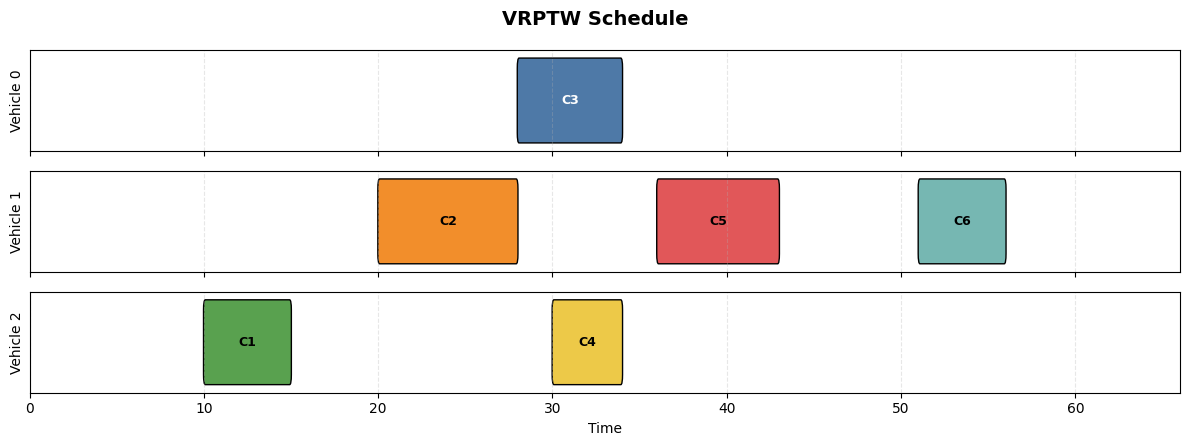

In [11]:
if result in (SAT, OPTIMUM):
    visu.reset()
    makespan = max(interval_value(main_visits[c]).end for c in range(n_customers))
    visu.timeline("VRPTW Schedule", origin=0, horizon=makespan + 10)
    
    # One panel per vehicle
    for v in range(n_vehicles):
        visu.panel(f"Vehicle {v}")
        
        # Only show customer visits, not depot
        for c in range(n_customers):
            val = interval_value(visits[v][c])
            if val is not None:
                customer_id = c + 1
                visu.interval(
                    val.start, val.end,
                    f"C{customer_id}",
                    color=customer_id
                )

    
    if visu.is_visu_enabled():
        visu.show()
    else:
        print("Visualization disabled (matplotlib not available)")

## Extensions

### Minimize Number of Vehicles

To minimize vehicles used instead of makespan:

In [12]:
# Example: Minimize number of vehicles used
# (not applied to model above)

# Count vehicles that have at least one visit
# vehicle_used[v] = 1 if any visit on vehicle v is present
# minimize(Sum(vehicle_used))

print("To minimize vehicles:")
print("  1. Create binary variables for vehicle usage")
print("  2. Link to presence of visits: vehicle_used[v] >= presence(visits[v][c])")
print("  3. minimize(Sum(vehicle_used))")

To minimize vehicles:
  1. Create binary variables for vehicle usage
  2. Link to presence of visits: vehicle_used[v] >= presence(visits[v][c])
  3. minimize(Sum(vehicle_used))


### Travel Distance Objective with ElementMatrix


```python
from pycsp3_scheduling.expressions.element import ElementMatrix
from pycsp3_scheduling import type_of_next

# Build cost matrix with special columns for boundary cases
M = ElementMatrix(
    matrix=cost_matrix,           # [from_type][to_type] costs (type 0 is depot)
    last_value=depot_distances,   # Return to depot (per type)
    absent_value=0,               # No cost if absent
)

# Objective: sum over all intervals (including depot departure)
for v in vehicles:
    depot_next = type_of_next(
        route[v], depot[v],
        last_value=M.last_type,      # Column index for "last in sequence"
        absent_value=M.absent_type,  # Column index for "absent"
    )
    distance += M[0, depot_next]

    for c in customers:
        type_i = c + 1  # Type 0 is depot
        next_type = type_of_next(
            route[v], visit[v][c],
            last_value=M.last_type,      # Column index for "last in sequence"
            absent_value=M.absent_type,  # Column index for "absent"
        )
        distance += M[type_i, next_type]

minimize(Sum(distance))
```

**Key components:**

| Component | Description |
|-----------|-------------|
| `ElementMatrix` | 2D matrix that supports expression indexing (like `IloNumArray2`) |
| `type_of_next` | Returns the type of the next interval in a sequence |
| `last_value` | Value returned when interval is last in sequence |
| `absent_value` | Value returned when interval is absent (optional) |
| `M[row, col]` | Element constraint accessing matrix with expression indices |


### Heterogeneous Fleet

Different vehicles with different capacities:

In [13]:
# Example: Heterogeneous fleet
vehicle_capacities = [20, 15, 10]  # Different capacities

print("For heterogeneous fleet:")
print("  - Use vehicle-specific capacity in constraints")
print("  - Can also have vehicle-specific costs")
print(f"  - Example capacities: {vehicle_capacities}")

For heterogeneous fleet:
  - Use vehicle-specific capacity in constraints
  - Can also have vehicle-specific costs
  - Example capacities: [20, 15, 10]


### Visit Synchronization

In many routing applications, some visits must be coordinated:
- **Pickup-Delivery**: Pickup must occur before delivery
- **Synchronized Services**: Multiple visits at the same time (e.g., team service)
- **Precedence**: One customer must be visited before another

In [14]:
# Example: Visit synchronization constraints
# (not applied to model above - showing patterns)

print("=== Visit Synchronization Patterns ===")
print()

# Pattern 1: Pickup-Delivery precedence
# Customer 1 (pickup) must be visited before Customer 4 (delivery)
print("1. Pickup-Delivery (precedence):")
print("   # Pickup at C1 must finish before delivery at C4 starts")
print("   satisfy(end_before_start(main_visits[0], main_visits[3]))")
print()

# Pattern 2: Same-time visits (synchronized service)
# Customer 2 and Customer 3 must be served at the same time (team service)
print("2. Synchronized visits (same start time):")
print("   # C2 and C3 must start at the same time")
print("   from pycsp3_scheduling import start_at_start")
print("   satisfy(start_at_start(main_visits[1], main_visits[2]))")
print()

# Pattern 3: Time-lagged visits
# Customer 5 must start exactly 10 time units after Customer 2 ends
print("3. Time-lagged visits:")
print("   # C5 starts 10 time units after C2 ends")
print("   from pycsp3_scheduling import end_before_start")
print("   satisfy(end_before_start(main_visits[1], main_visits[4], delay=10))")
print()

# Pattern 4: Same vehicle constraint
# Customer 1 and Customer 4 must be on the same vehicle (pickup-delivery pair)
print("4. Same vehicle (pickup-delivery on same route):")
print("   # C1 and C4 must be on the same vehicle")
print("   for v in range(n_vehicles):")
print("       # If C1 is on vehicle v, then C4 must also be on vehicle v")
print("       satisfy(presence_of(visits[v][0]) == presence_of(visits[v][3]))")
print()

# Pattern 5: Synchronize constraint (same time and same vehicle)
print("5. Synchronize (intervals share same start time):")
print("   # All visits in a group start at the same time as a reference interval")
print("   satisfy(synchronize(reference_interval, [sync_visit1, sync_visit2]))")

=== Visit Synchronization Patterns ===

1. Pickup-Delivery (precedence):
   # Pickup at C1 must finish before delivery at C4 starts
   satisfy(end_before_start(main_visits[0], main_visits[3]))

2. Synchronized visits (same start time):
   # C2 and C3 must start at the same time
   from pycsp3_scheduling import start_at_start
   satisfy(start_at_start(main_visits[1], main_visits[2]))

3. Time-lagged visits:
   # C5 starts 10 time units after C2 ends
   from pycsp3_scheduling import end_before_start
   satisfy(end_before_start(main_visits[1], main_visits[4], delay=10))

4. Same vehicle (pickup-delivery on same route):
   # C1 and C4 must be on the same vehicle
   for v in range(n_vehicles):
       # If C1 is on vehicle v, then C4 must also be on vehicle v
       satisfy(presence_of(visits[v][0]) == presence_of(visits[v][3]))

5. Synchronize (intervals share same start time):
   # All visits in a group start at the same time as a reference interval
   satisfy(synchronize(reference_interva

## Summary

This notebook demonstrated VRPTW modeling with:

1. **Optional intervals** for vehicle-customer assignments
2. **Alternative constraints** for customer coverage  
3. **Sequence variables** with transition matrices for travel times
4. **Capacity constraints** using `presence_time()`
5. **ElementMatrix + type_of_next** for travel distance objective
6. **Visit synchronization** patterns (precedence, same-time, time-lagged)

### Key Modeling Pattern

```python
# For each customer, one visit per vehicle (optional)
visits[v][c] = IntervalVar(start=(earliest, latest), size=service, optional=True)

# Main visit (abstract) for the customer
main_visit[c] = IntervalVar(start=(earliest, latest), size=service)

# Exactly one vehicle visits each customer
satisfy(alternative(main_visit[c], [visits[v][c] for v in vehicles]))

# Include a depot interval per vehicle (fixed at time 0)
depot[v] = IntervalVar(start=0, size=0)
route[v] = SequenceVar(intervals=[depot[v]] + visits[v], types=[0] + [c + 1 for c in customers])

# Travel times between nodes (including depot) on each route
satisfy(SeqNoOverlap(route[v], transition_matrix=travel_times))

# Distance objective using type_of_next (includes depot departure)
M = ElementMatrix(matrix=costs, last_value=depot_costs, absent_value=0)
depot_next = type_of_next(route[v], depot[v], M.last_type, M.absent_type)
distance_terms.append(M[0, depot_next])
distance_terms.append(M[type_i, type_of_next(route, interval, M.last_type, M.absent_type)])
minimize(Sum(distance_terms))
```

### Objective Options

| Objective | Approach | Notes |
|-----------|----------|-------|
| Min makespan | `minimize(Maximum(end_time(...)))` | Latest completion |
| Min total time | `minimize(Sum(end_time(...)))` | Proxy for travel |
| Min vehicles | `minimize(Sum(vehicle_used[v]))` | Count active routes |
| **Min travel** | **`ElementMatrix` + `type_of_next`** | **Exact distance** |

### Synchronization Patterns

| Pattern | Constraint | Use Case |
|---------|------------|----------|
| Precedence | `end_before_start(a, b)` | Pickup before delivery |
| Same time | `start_at_start(a, b)` | Team service |
| Time lag | `end_before_start(a, b, delay=k)` | Minimum separation |
| Same vehicle | `presence_of(v_a) == presence_of(v_b)` | Pickup-delivery pairs |
| Synchronize | `synchronize(ref, [a, b])` | Coordinated visits |
